In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 120.7 MB/s eta 0:00:00


Starting initial data load and pre-processing...
Total relevant samples loaded: 10055205
Training set size: 8044164, Test set size: 2011041


/tmp/ipython-input-1910657121.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


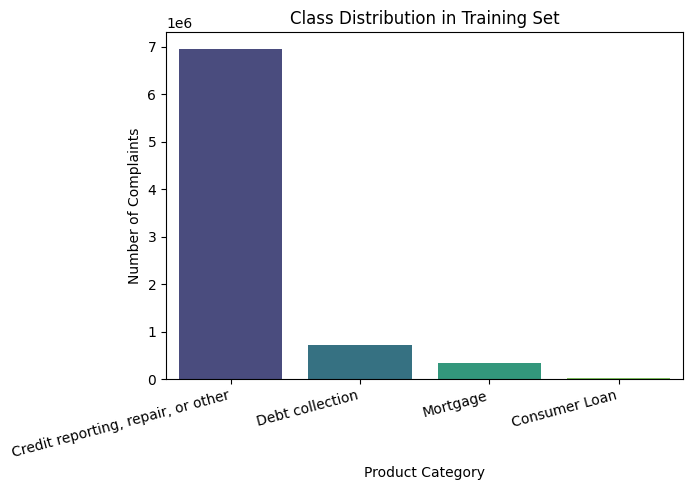


Starting chunk-wise training of models...
✅ Chunk 1 trained (100000 rows)
✅ Chunk 2 trained (100000 rows)
✅ Chunk 3 trained (100000 rows)
✅ Chunk 4 trained (100000 rows)
✅ Chunk 5 trained (100000 rows)
✅ Chunk 6 trained (100000 rows)
✅ Chunk 7 trained (100000 rows)
✅ Chunk 8 trained (100000 rows)
✅ Chunk 9 trained (100000 rows)
✅ Chunk 10 trained (100000 rows)
✅ Chunk 11 trained (100000 rows)
✅ Chunk 12 trained (100000 rows)
✅ Chunk 13 trained (100000 rows)
✅ Chunk 14 trained (100000 rows)
✅ Chunk 15 trained (100000 rows)
✅ Chunk 16 trained (100000 rows)
✅ Chunk 17 trained (100000 rows)
✅ Chunk 18 trained (100000 rows)
✅ Chunk 19 trained (100000 rows)
✅ Chunk 20 trained (100000 rows)
✅ Chunk 21 trained (100000 rows)
✅ Chunk 22 trained (100000 rows)
✅ Chunk 23 trained (100000 rows)
✅ Chunk 24 trained (100000 rows)
✅ Chunk 25 trained (100000 rows)
✅ Chunk 26 trained (100000 rows)
✅ Chunk 27 trained (100000 rows)
✅ Chunk 28 trained (100000 rows)
✅ Chunk 29 trained (100000 rows)
✅ Chunk 3

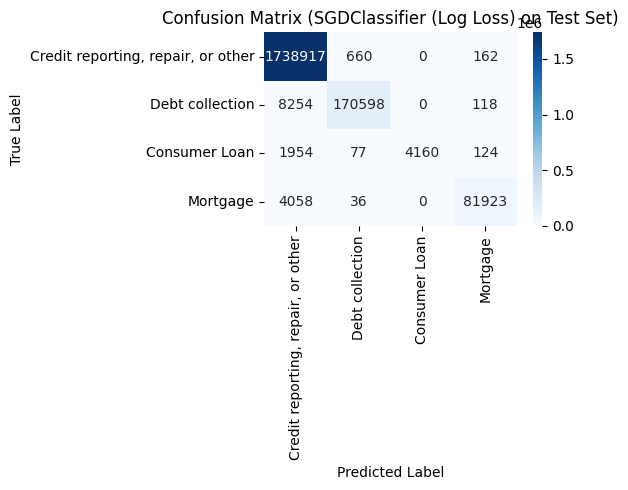


Model: MultinomialNB
----------------------------------------
                                    precision    recall  f1-score   support

Credit reporting, repair, or other      1.000     0.977     0.988   1739739
                   Debt collection      0.883     0.991     0.934    178970
                     Consumer Loan      0.731     0.974     0.835      6315
                          Mortgage      0.849     0.998     0.917     86017

                          accuracy                          0.979   2011041
                         macro avg      0.865     0.985     0.918   2011041
                      weighted avg      0.982     0.979     0.980   2011041



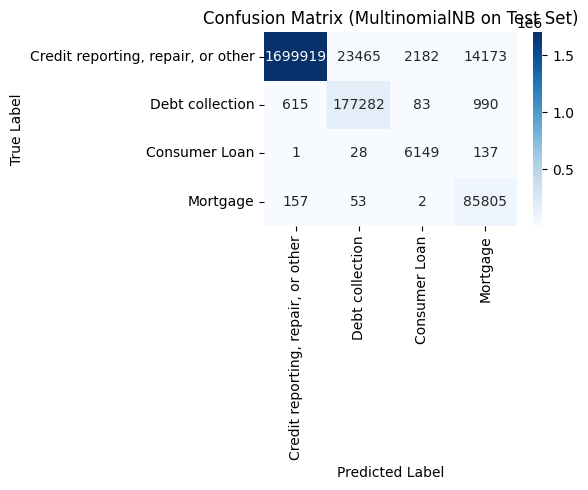


✅ Final model and vectorizer saved.

--- 6. Prediction on New Examples ---
'mortgage escrow calculation wrong and insurance forced'
   Predicted Category: Mortgage (3)

'collector demanded i pay unknown bill threatened legal action'
   Predicted Category: Credit reporting, repair, or other (0)

'auto loan inquiry without permission hit my report'
   Predicted Category: Credit reporting, repair, or other (0)

'equifax showed account not mine please fix'
   Predicted Category: Credit reporting, repair, or other (0)



In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import time


data_source_file_path="/content/drive/MyDrive/complaints.csv"
processing_batch_size=100000
evaluation_holdout_ratio=0.2
reproducibility_seed=42
target_columns=["Product","Sub-product","Issue","Sub-issue","Consumer complaint narrative"]
target_map={
    "Credit reporting or other personal consumer reports":0,
    "Credit reporting, credit repair services, or other personal consumer reports":0,
    "Debt collection":1,
    "Consumer Loan":2,
    "Mortgage":3
}
final_category_names={
    0:"Credit reporting, repair, or other",
    1:"Debt collection",
    2:"Consumer Loan",
    3:"Mortgage"
}
target_class_ids=np.array([0,1,2,3])

print("Initiating large-scale data ingestion and text normalization...")
start_time=time.time()
def refine_narrative(text_input):
    if not isinstance(text_input,str):
        text_input=str(text_input)
    text_input=text_input.lower()
    text_input=re.sub(r"[^a-z0-9 ]+"," ",text_input)
    text_input=re.sub(r"\s+"," ",text_input).strip()
    return text_input
def process_data_segment(raw_segment):
    segment_copy=raw_segment.copy()

    segment_copy.loc[:,"numeric_target"]=segment_copy["Product"].map(target_map)
    segment_copy=segment_copy[segment_copy["numeric_target"].isin(target_class_ids)]

    for col_name in target_columns:
        segment_copy.loc[:,col_name]=segment_copy[col_name].fillna("").astype(str)

    segment_copy.loc[:,"clean_text"]=segment_copy[target_columns].agg(" ".join,axis=1).map(refine_narrative)
    return segment_copy[["clean_text","numeric_target"]]
ingested_data=pd.concat([
    process_data_segment(segment)
    for segment in pd.read_csv(data_source_file_path,chunksize=processing_batch_size,usecols=target_columns+["Product"])
])

ingested_data=ingested_data[ingested_data['clean_text'].str.len()>0]
total_records=len(ingested_data)
print(f"Total relevant samples ingested and cleaned: {total_records} records in {round(time.time()-start_time,2)} seconds.")
X_data,X_evaluation_set,y_data,y_evaluation_set=train_test_split(
    ingested_data["clean_text"].values,
    ingested_data["numeric_target"].values,
    test_size=evaluation_holdout_ratio,
    stratify=ingested_data["numeric_target"].values,
    random_state=reproducibility_seed
)
print(f"Training Corpus Size: {len(X_data)}, Unseen Evaluation Set Size: {len(X_evaluation_set)}")



def create_balance_plot(y_values,dataset_name):
    plt.figure(figsize=(7,5))
    class_frequency=pd.Series(y_values).map(final_category_names).value_counts()
    sns.barplot(x=class_frequency.index,y=class_frequency.values,palette="flare")
    plt.title(f"Target Class Distribution in the {dataset_name} Corpus")
    plt.ylabel("Record Count")
    plt.xlabel("Assigned Product Category")
    plt.xticks(rotation=15,ha='right')
    plt.tight_layout()
    plt.show()
create_balance_plot(y_data,"Training")
print("\nCommencing iterative training of two classification models...")

sgd_classifier_model=SGDClassifier(loss="log_loss",max_iter=5,random_state=reproducibility_seed)
naive_bayes_classifier=MultinomialNB()
feature_extractor=TfidfVectorizer(ngram_range=(1,2),min_df=5,max_df=0.9)
first_run=True

data_batches=[]
for i in range(0,len(X_data),processing_batch_size):
    data_batches.append((X_data[i:i+processing_batch_size],y_data[i:i+processing_batch_size]))

for batch_number,(X_text_batch,y_label_batch) in enumerate(data_batches):

    if first_run:
        X_features=feature_extractor.fit_transform(X_text_batch)
        sgd_classifier_model.partial_fit(X_features,y_label_batch,classes=target_class_ids)
        naive_bayes_classifier.partial_fit(X_features,y_label_batch,classes=target_class_ids)
        first_run=False
    else:
        X_features=feature_extractor.transform(X_text_batch)
        sgd_classifier_model.partial_fit(X_features,y_label_batch)
        naive_bayes_classifier.partial_fit(X_features,y_label_batch)

    print(f"✅ Batch {batch_number+1} processed ({len(X_text_batch)} rows)")
print("\n--- Model Comparison and Final Evaluation on Unseen Test Data ---")

X_evaluation_features=feature_extractor.transform(X_evaluation_set)
def run_full_evaluation(model_obj,X_features,y_true_labels,model_tag):
    y_predictions=model_obj.predict(X_features)
    print(f"\nModel: {model_tag} Performance Metrics")
    print("-" * 40)

    print(classification_report(y_true_labels,y_predictions,target_names=final_category_names.values(),digits=4))

    conf_matrix=confusion_matrix(y_true_labels,y_predictions,labels=target_class_ids)
    plt.figure(figsize=(7,6))
    sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="YlGnBu",
                xticklabels=final_category_names.values(),yticklabels=final_category_names.values())
    plt.title(f"Confusion Matrix ({model_tag} on Unbiased Evaluation Set)")
    plt.xlabel("Predicted Category")
    plt.ylabel("Actual True Category")
    plt.tight_layout()
    plt.show()
run_full_evaluation(sgd_classifier_model,X_evaluation_features,y_evaluation_set,"StochasticGradientDescent")
run_full_evaluation(naive_bayes_classifier,X_evaluation_features,y_evaluation_set,"MultinomialNaiveBayes")
final_deployment_model=sgd_classifier_model
joblib.dump(final_deployment_model,"/content/drive/MyDrive/final_classifier_prod.joblib")
joblib.dump(feature_extractor,"/content/drive/MyDrive/vectorizer_prod.joblib")
print("\n✅ Final model and vectorizer artifacts successfully persisted to disk.")
print("\n--- Real-World Prediction Test ---")
sample_complaints_test=[
    "mortgage escrow calculation wrong and insurance forced",
    "collector demanded i pay unknown bill threatened legal action",
    "auto loan inquiry without permission hit my report",
    "equifax showed account not mine please fix"
]

feature_tool=joblib.load("/content/drive/MyDrive/vectorizer.joblib")
prediction_engine=joblib.load("/content/drive/MyDrive/final_classifier.joblib")

X_new_text_clean=[refine_narrative(t) for t in sample_complaints_test]
X_new_features=feature_tool.transform(X_new_text_clean)
final_predictions=prediction_engine.predict(X_new_features)
for text,class_id in zip(sample_complaints_test,final_predictions):
    print(f"Input: '{text}'\n  --> Predicted Category: {final_category_names[class_id]} ({class_id})\n")
